# Latent Space as a similarity index

In [1]:
import scipy as sp

from plots import plot_vox, plot_dots

import numpy as np
from keras.utils import to_categorical


from data import load_data, load_custom_model

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet40/')
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

def accuracy(y_pred, y_test):
    return np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0]

eval_model = load_custom_model('./models/eval_model_net40_acc_08047.hdf5')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
dim is deprecated, use axis instead


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [26]:
from keras.models import Model
%matplotlib inline


latent_mask = Model(eval_model.input, eval_model.layers[-3].output)
# latent_length = Model(eval_model.input, eval_model.layers[-2].output)
latent_capsule = Model(eval_model.input, eval_model.layers[-4].output)
corpus_mask = latent_mask.predict(x_test)
corpus_capsule = latent_capsule.predict(x_test)

In [12]:
def compare(a, b, latent_space):
    y_pred = latent_space.predict(a.reshape(1, 30, 30, 30, 1))
    y_pred_2 = latent_space.predict(b.reshape(1, 30, 30, 30, 1))
    plot_vox(a, b)
    return sp.spatial.distance.cosine(y_pred, y_pred_2.T)

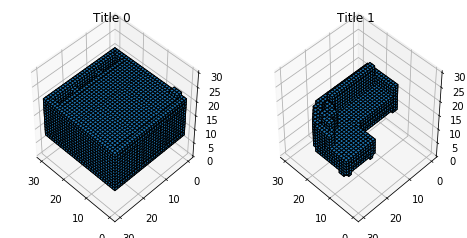

1.0

In [25]:
compare(x_test[20], x_test[100], latent_mask)